# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [27]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223
HopsworksSettings initialized!


In [28]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [29]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 13, 15, 29, 31, 166175)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [30]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-13 15:29:31,181 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-13 15:29:31,195 INFO: Initializing external client
2025-11-13 15:29:31,196 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-13 15:29:31,783 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-13 15:29:32,619 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272012


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [31]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=5,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-13 15:29:36,987 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/583664 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/121324 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/46693 elapsed<00:00 remaining<?

In [32]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.2440874E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'i', 'i', 'i', 'i', 'i', 'i', 'i',
                            'i', 'i', 'i', 'i', 'i'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [33]:
def add_month_feat(df):
    df = df.copy()

    # extract month number
    df["month"] = pd.to_datetime(df["date"]).dt.month

    # create OHE with all 12 possible months
    month_ohe = pd.get_dummies(df["month"], prefix="month")

    # ensure all 12 columns exist
    for m in range(1, 13):
        col = f"month_{m}"
        if col not in month_ohe.columns:
            month_ohe[col] = 0

    # order columns 1 → 12
    month_ohe = month_ohe[[f"month_{m}" for m in range(1, 13)]]

    return pd.concat([df, month_ohe], axis=1)

In [34]:
import numpy as np

weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

df_prev = (
    air_quality_fg
        .read()
)

df_prev.sort_values('date', inplace=True)


df_prev.sort_values('date', inplace=True)
pm25_last3 = df_prev["pm25"].tail(3).to_list()

pm25_3days_ago, pm25_2days_ago, pm25_1days_ago = pm25_last3

batch_data = weather_fg.filter(weather_fg.date >= today).read()


batch_data = add_month_feat(batch_data)
batch_data.drop(columns="month", inplace=True)

# things we are missing: rolling
batch_data.sort_values("date", inplace=True)
batch_data[["rolling1", "rolling2", "rolling3", "predicted_pm25"]] = np.nan


batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,month_1,month_2,month_3,month_4,...,month_7,month_8,month_9,month_10,month_11,month_12,rolling1,rolling2,rolling3,predicted_pm25
5,2025-11-14 00:00:00+00:00,2.50,0.0,14.587776,285.751251,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN
0,2025-11-15 00:00:00+00:00,2.05,0.0,10.163227,247.067871,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN
4,2025-11-16 00:00:00+00:00,2.85,0.0,12.599999,270.000000,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN
2,2025-11-17 00:00:00+00:00,0.70,0.0,17.418196,341.939423,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN
3,2025-11-18 00:00:00+00:00,0.00,0.0,4.452954,255.963730,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN
1,2025-11-19 00:00:00+00:00,-1.45,0.0,6.480000,360.000000,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN


In [35]:
batch_data = batch_data.sort_values("date").reset_index(drop=True)
batch_data.columns

Index(['date', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rolling1',
       'rolling2', 'rolling3', 'predicted_pm25'],
      dtype='object')

In [36]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,month_1,month_2,month_3,month_4,...,month_7,month_8,month_9,month_10,month_11,month_12,rolling1,rolling2,rolling3,predicted_pm25
0,2025-11-14 00:00:00+00:00,2.50,0.0,14.587776,285.751251,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN
1,2025-11-15 00:00:00+00:00,2.05,0.0,10.163227,247.067871,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN
2,2025-11-16 00:00:00+00:00,2.85,0.0,12.599999,270.000000,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN
3,2025-11-17 00:00:00+00:00,0.70,0.0,17.418196,341.939423,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN
4,2025-11-18 00:00:00+00:00,0.00,0.0,4.452954,255.963730,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN
5,2025-11-19 00:00:00+00:00,-1.45,0.0,6.480000,360.000000,hedemora,0,0,0,0,...,0,0,0,0,True,0,NaN,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [37]:
expected_cols = retrieved_xgboost_model.get_booster().feature_names

for idx, row in batch_data.iterrows():

    batch_data.loc[idx, "rolling1"] = pm25_1days_ago
    batch_data.loc[idx, "rolling2"] = pm25_2days_ago
    batch_data.loc[idx, "rolling3"] = pm25_3days_ago

    batch_data =batch_data.astype({
    "rolling1": "float32",
    "rolling2": "float32",
    "rolling3": "float32"
    })
    
    # lets predict :)
    row = batch_data.loc[[idx], expected_cols]
    row = row.astype("float32")

    pred = retrieved_xgboost_model.predict(row)[0]

    batch_data.loc[idx, "predicted_pm25"] = pred

    pm25_3days_ago = pm25_2days_ago
    pm25_2days_ago = pm25_1days_ago
    pm25_1days_ago = pred

    

batch_data =batch_data.astype({
    "predicted_pm25": "float32"
    })
batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,month_1,month_2,month_3,month_4,...,month_7,month_8,month_9,month_10,month_11,month_12,rolling1,rolling2,rolling3,predicted_pm25
0,2025-11-14 00:00:00+00:00,2.50,0.0,14.587776,285.751251,hedemora,0,0,0,0,...,0,0,0,0,True,0,3.000000,11.000000,22.000000,11.148751
1,2025-11-15 00:00:00+00:00,2.05,0.0,10.163227,247.067871,hedemora,0,0,0,0,...,0,0,0,0,True,0,11.148751,3.000000,11.000000,18.794138
2,2025-11-16 00:00:00+00:00,2.85,0.0,12.599999,270.000000,hedemora,0,0,0,0,...,0,0,0,0,True,0,18.794138,11.148751,3.000000,21.192865
3,2025-11-17 00:00:00+00:00,0.70,0.0,17.418196,341.939423,hedemora,0,0,0,0,...,0,0,0,0,True,0,21.192865,18.794138,11.148751,15.480511
4,2025-11-18 00:00:00+00:00,0.00,0.0,4.452954,255.963730,hedemora,0,0,0,0,...,0,0,0,0,True,0,15.480511,21.192865,18.794138,20.550117
5,2025-11-19 00:00:00+00:00,-1.45,0.0,6.480000,360.000000,hedemora,0,0,0,0,...,0,0,0,0,True,0,20.550117,15.480511,21.192865,22.490850


In [38]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   month_1                      6 non-null      int64                  
 7   month_2                      6 non-null      int64                  
 8   month_3                      6 non-null      int64                  
 9   month_4                      6 non-null      int64                  
 10  month_

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [39]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,month_1,month_2,month_3,month_4,...,month_10,month_11,month_12,rolling1,rolling2,rolling3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-14 00:00:00+00:00,2.50,0.0,14.587776,285.751251,hedemora,0,0,0,0,...,0,True,0,3.000000,11.000000,22.000000,11.148751,gussarvsgatan,sweden,1
1,2025-11-15 00:00:00+00:00,2.05,0.0,10.163227,247.067871,hedemora,0,0,0,0,...,0,True,0,11.148751,3.000000,11.000000,18.794138,gussarvsgatan,sweden,2
2,2025-11-16 00:00:00+00:00,2.85,0.0,12.599999,270.000000,hedemora,0,0,0,0,...,0,True,0,18.794138,11.148751,3.000000,21.192865,gussarvsgatan,sweden,3
3,2025-11-17 00:00:00+00:00,0.70,0.0,17.418196,341.939423,hedemora,0,0,0,0,...,0,True,0,21.192865,18.794138,11.148751,15.480511,gussarvsgatan,sweden,4
4,2025-11-18 00:00:00+00:00,0.00,0.0,4.452954,255.963730,hedemora,0,0,0,0,...,0,True,0,15.480511,21.192865,18.794138,20.550117,gussarvsgatan,sweden,5
5,2025-11-19 00:00:00+00:00,-1.45,0.0,6.480000,360.000000,hedemora,0,0,0,0,...,0,True,0,20.550117,15.480511,21.192865,22.490850,gussarvsgatan,sweden,6


In [40]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   month_1                      6 non-null      int64                  
 7   month_2                      6 non-null      int64                  
 8   month_3                      6 non-null      int64                  
 9   month_4                      6 non-null      int64                  
 10  month_

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

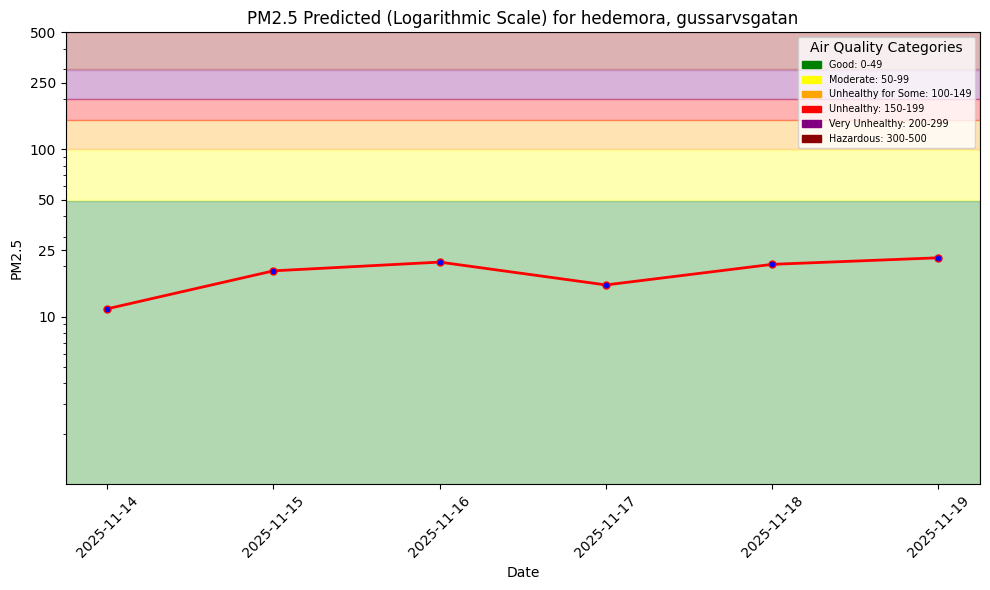

In [41]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [42]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [46]:
colinos = ['date', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city','predicted_pm25', 'street', 'country',
       'days_before_forecast_day']
insetion = batch_data[colinos]

In [47]:
monitor_fg.insert(insetion, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272012/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-13 15:32:11,458 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-13 15:32:17,826 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-13 15:34:09,279 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-13 15:34:09,462 INFO: Waiting for log aggregation to finish.
2025-11-13 15:34:21,378 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [ ]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-15 00:00:00+00:00,2.05,0.0,10.163227,247.067871,hedemora,34.557251,gussarvsgatan,sweden,1


In [ ]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 


,date,pm25,country,city,street,url,rolling1,rolling2,rolling3
0,2025-06-10 00:00:00+00:00,14.0,sweden,hedemora,gussarvsgatan,https://api.waqi.info/feed/@12727,13.0,10.0,5.0
1,2025-08-26 00:00:00+00:00,5.0,sweden,hedemora,gussarvsgatan,https://api.waqi.info/feed/@12727,5.0,4.0,4.0
2,2020-09-27 00:00:00+00:00,20.0,sweden,hedemora,gussarvsgatan,https://api.waqi.info/feed/@12727,10.0,22.0,53.0
3,2021-09-22 00:00:00+00:00,19.0,sweden,hedemora,gussarvsgatan,https://api.waqi.info/feed/@12727,22.0,18.0,18.0
4,2022-11-02 00:00:00+00:00,23.0,sweden,hedemora,gussarvsgatan,https://api.waqi.info/feed/@12727,24.0,24.0,18.0
...,...,...,...,...,...,...,...,...,...
2018,2025-09-03 00:00:00+00:00,16.0,sweden,hedemora,gussarvsgatan,https://api.waqi.info/feed/@12727,27.0,29.0,23.0
2019,2023-04-16 00:00:00+00:00,31.0,sweden,hedemora,gussarvsgatan,https://api.waqi.info/feed/@12727,33.0,24.0,48.0
2020,2025-06-22 00:00:00+00:00,8.0,sweden,hedemora,gussarvsgatan,https://api.waqi.info/feed/@12727,8.0,7.0,8.0
2021,2024-12-05 00:00:00+00:00,45.0,sweden,hedemora,gussarvsgatan,https://api.waqi.info/feed/@12727,30.0,11.0,15.0


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 


Uploading Dataframe: 100.00% |██████████| Rows 4/4 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272012/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-13 14:32:10,932 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-13 14:32:14,110 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-13 14:34:10,775 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-13 14:34:10,930 INFO: Waiting for log aggregation to finish.
2025-11-13 14:34:19,654 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-11-10 00:00:00+00:00,5.265166,0.3,8.037761,99.301048,hedemora,24.806309,6.0,gussarvsgatan,sweden,1
1,2025-11-11 00:00:00+00:00,5.588084,0.0,12.496719,193.872818,hedemora,36.075691,22.0,gussarvsgatan,sweden,1
2,2025-11-12 00:00:00+00:00,7.669333,4.6,26.548626,201.186218,hedemora,27.037188,11.0,gussarvsgatan,sweden,1
3,2025-11-13 00:00:00+00:00,5.400000,0.0,12.496718,318.503632,hedemora,18.358715,3.0,gussarvsgatan,sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

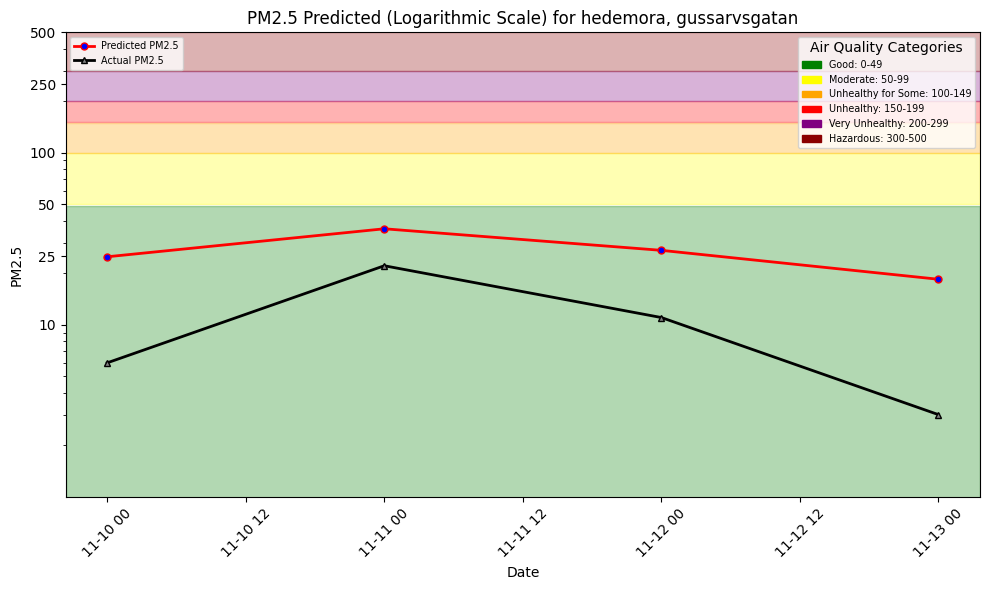

In [ ]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/docs/air-quality/assets/img/pm25_forecast.png: 0.0…

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/docs/air-quality/assets/img/pm25_hindcast_1day.png…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272012/settings/fb/path/Resources/airquality


---